In [1]:
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import atomai as aoi

/opt/anaconda/envs/shared_conda_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
aoi.__version__ #check version. It should have review in it; current version is

'0.7.8_review_'

### Following options are availabe for loading:-
- Au: Au_Bal_MedFilt_cutimages_20190726.h5
- Au maps: Au_Bal_unFilt_cutimages_20190423_maps.h5

- CdSe: Bal_MedFilt_CdSeRelabel512Images_20190726.h5
- CdSe maps: Bal_unFilt_CdSeRelabel512Images_20190724_maps.h5

- Au+ CdSe: Bal_MedFilt_AuCdSeDots_20190726_v2.h5
- Au + CdSe maps: Bal_unFilt_CdSeRelabel512Images_20190724_maps.h5

In [41]:
#loading Au HRTEM file
with h5py.File('data_pv/hrtem_cdse_au/Au_Bal_MedFilt_cutimages_20190726.h5', 'r') as f:
    print(f.keys())
    data = f.get('images')[()]

<KeysViewHDF5 ['images']>


In [6]:
with h5py.File('data_pv/hrtem_cdse_au/Au_Bal_unFilt_cutimages_20190423_maps.h5') as f:
    print(f.keys())
    data2 = f.get('maps')[()]

<KeysViewHDF5 ['maps']>


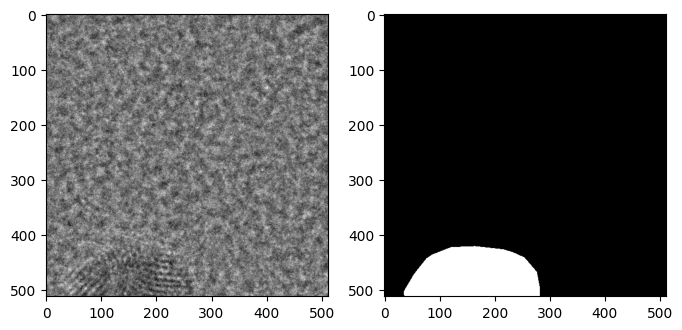

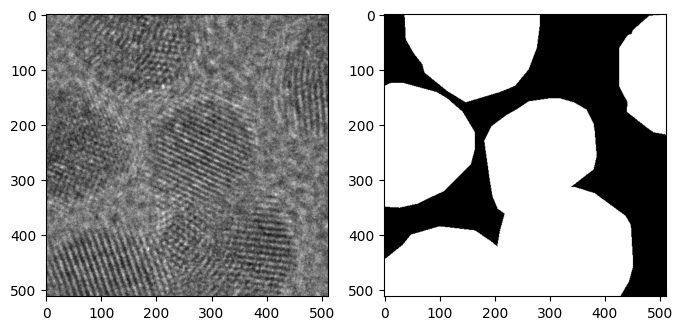

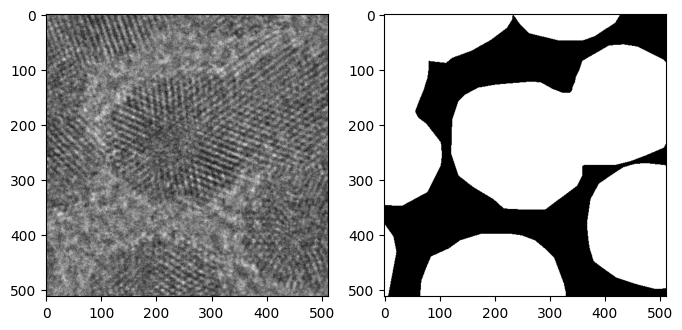

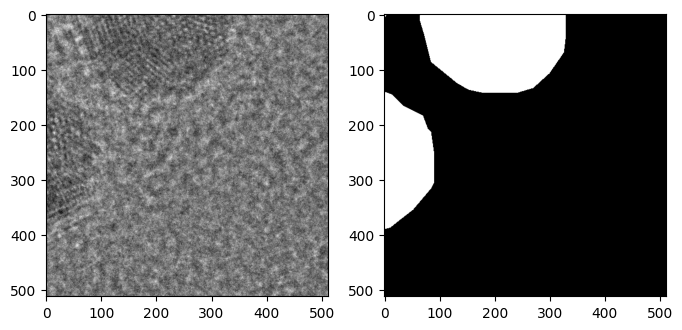

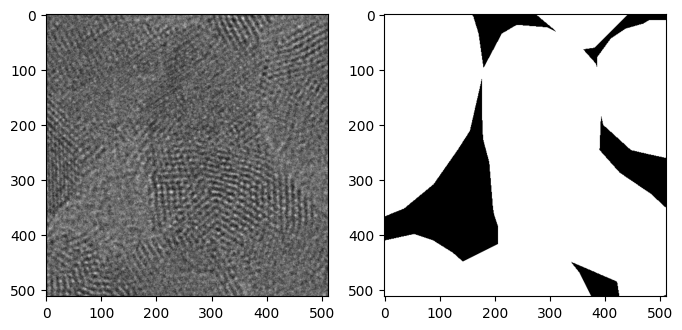

In [7]:
for i in range(0,20,4):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (8,5))
    ax1.imshow(data[i,:,:], cmap='gray')
    ax2.imshow(data2[i,:,:,1], cmap='gray')    
    plt.show()

#### Reshape of train/labels data for Unet

For multiclass cases:

Train data, 4 dims = (n_images, n_channels=1, image_height, image_width) \
Labels data 3 dims = (n_images, image_height, image_width)\

# Instead of reshape, we try data aug

In [8]:
from atomai.transforms import datatransform

In [9]:
def remove_empty(threshold=10):
    clean_imgs=[]
    clean_labels=[]
    for img,label in zip(data,data2):
        if np.sum(label[:,:,1])>threshold:
            clean_imgs.append(img)            
            clean_labels.append(label)
    return clean_imgs,clean_labels

In [10]:
imgs,lbls_re=remove_empty()

### number of images in file
- Au: 216 [215 non-zero]
- CdSe: 172
- Au & CdSe: 258


In [11]:
imgs_re0=np.reshape(imgs,(215,512,512)) #reshape according to number of images in the file
lbls_re0=np.array(lbls_re)

In [12]:
from sklearn.model_selection import train_test_split


In [13]:
imgs_re,_ , lbls_re,_ = train_test_split(imgs_re0,lbls_re0,test_size=0.2,random_state=42) #hitch a hike to the galxy!!!

In [14]:
X_train_pre, X_test_pre, y_train_pre, y_test_pre=train_test_split(imgs_re,lbls_re,test_size=0.25,random_state=42) #hitch a hike to the galxy!!!

In [15]:
X_test=np.reshape(X_test_pre,(43,1,512,512)) #reshaping to atomai's spcifications
y_test=np.zeros((43,512,512))

In [16]:
y_test[y_test_pre[:,:,:,0] == 1] = 0
y_test[y_test_pre[:,:,:,1] == 1] = 1

In [17]:
def imgen(rotat=True, mode="contrast"):
    '''
    To assist multimodal dataaugmentation. user can specify their own mode.
    Uses the datatransform module alone
    '''
    ch = 2
    
    
    
    if mode=="contrast":
        imaug=datatransform(
            n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',rotation=rotat,
            contrast=True,squeeze_channels=True)

    if mode=="blur":
        imaug = datatransform(
        n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first', rotation=rotat,
        blur=True,squeeze_channels=True)
    
    if mode=='gauss_noise':
        imaug = datatransform(
        n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first', rotation=rotat,
        gauss_noise=True,squeeze_channels=True)
        
    if mode=='background':
        imaug = datatransform(
        n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first', rotation=rotat,
        background=True,squeeze_channels=True)
    if mode=='rotat':
        imaug=datatransform(
            n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',rotation=rotat,
            squeeze_channels=True)
    
    
    
    imm,lbb=X_train_pre,y_train_pre
    
    lbb = lbb[..., None] if np.ndim(lbb) == 3 else lbb
    
    images_all, labels_all = imaug.run(imm, lbb)
    return images_all, labels_all

In [18]:
def imagesmake(mode='contrast'):
    print(mode)
    
    max_epochs=20
    image_fin,lbl_fin=imgen(rotat=True,mode=mode)
    image_fin_full=image_fin
    lbl_fin_full=lbl_fin
    for epoch in range(max_epochs-1):
        image_fin,lbl_fin=imgen(rotat=True,mode=mode)
        image_fin_full=np.concatenate((image_fin_full,image_fin))
        lbl_fin_full=np.concatenate((lbl_fin_full,lbl_fin))
        print(len(lbl_fin_full))
    return image_fin_full, lbl_fin_full

        
    

In [19]:
image_fin,lbl_fin=imagesmake('blur') #prints te total number of images produced

blur
258
387
516
645
774
903
1032
1161
1290
1419
1548
1677
1806
1935
2064
2193
2322
2451
2580


In [20]:
X_train, X_val, y_train, y_val=train_test_split(
    image_fin,lbl_fin, test_size=0.2, random_state=42)

In [21]:
np.save('data_out_pv/X_train.npy',X_train)

In [22]:
np.save('data_out_pv/X_test.npy',X_test)

In [23]:
np.save('data_out_pv/X_val.npy',X_val)

In [24]:
np.save('data_out_pv/y_train.npy',y_train) 


In [25]:
np.save('data_out_pv/y_val.npy',y_val) 


In [ ]:
y_train.shape,y_test.shape,y_val.shape #ok ig

In [26]:
np.save('data_out_pv/y_test.npy',y_test)